In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

import numpy as np
import random
import copy
import time
from sklearn.model_selection import train_test_split

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"



from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/jupyter-hamin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
base_path = "/home/jupyter-hamin/OCR_sideproj/data"

pixel_size = 1600

with open(f"{base_path}/crop_{pixel_size}_good.npy", 'rb') as f:
    crop_images = np.load(f)
    
with open(f"{base_path}/scan_{pixel_size}_good.npy", 'rb') as f:
    scan_images = np.load(f)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(crop_images, scan_images, test_size=0.1, random_state=42)


In [16]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from PIL import Image


class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, transform_input=None, transform_output=None, 
                 transform_input_perc=None, transform_output_perc=None):
        self.transform_input = transform_input
        self.transform_output = transform_output
        
        self.transform_input_perc = transform_input_perc
        self.transform_output_perc = transform_output_perc

        self.data = np.transpose(x_data, (0, 3, 1, 2))
        self.targets = np.transpose(y_data, (0, 3, 1, 2))

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1, 2, 0))
        y = Image.fromarray(self.targets[index].astype(np.uint8).transpose(1, 2, 0))
        
        if self.transform_input_perc is None:
            x1 = self.transform_input(x)
            y1 = self.transform_output(y)
            return x1, y1
        else:
            x1 = self.transform_input(x)
            y1 = self.transform_output(y)
            x2 = self.transform_input_perc(x)
            y2 = self.transform_output_perc(y)

            return x1, x2, y1, y2


In [17]:
norm_mean = [ 0.485, 0.456, 0.406 ]
norm_std  = [ 0.229, 0.224, 0.225 ]

transform_train = transforms.Compose([
#     transforms.RandomApply(torch.nn.ModuleList([
#         transforms.RandomAffine(degrees=[-10,10], translate=[0.00,0.01], scale=[0.9,1.00], shear=1, fill=(0,0,0)),
        
#      ]), p=0.25),
    
#     transforms.RandomApply(torch.nn.ModuleList([
#         transforms.ColorJitter(brightness=(0.5, 1.5), contrast=0.3, saturation=0.1, hue=0.1),
#      ]), p=0.25),

    #transforms.RandomGrayscale(p=0.1),
#     transforms.RandomApply(torch.nn.ModuleList([
#          transforms.GaussianBlur(3, sigma=(0.8, 1.2)),
#      ]), p=0.1),
    
#     transforms.RandomPerspective(distortion_scale=0.1, p=0.25),
#     transforms.RandomApply(torch.nn.ModuleList([
#          transforms.ElasticTransform(),
#      ]), p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = norm_mean, std = norm_std),
])


transform_output = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = norm_mean, std = norm_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = norm_mean, std = norm_std),

])


In [18]:
train_set = CustomDataset(x_train, y_train,
                          transform_input=transform_train, 
                          transform_output=transform_output, 
                         )
trainloader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, num_workers=32,persistent_workers=True,
                                          #prefetch_factor=8, pin_memory=True
                                         )

test_set = CustomDataset(x_test, y_test, 
                          transform_input=transform_test, 
                          transform_output=transform_output, 
                        )
testloader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=32,persistent_workers=True,
                                        #prefetch_factor=4, pin_memory=True
                                        )

In [19]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [21]:
from models.u2net import RSU7, RSU6, RSU5, RSU4, RSU4F, _upsample_like

class U2NETP(nn.Module):

    def __init__(self,in_ch=3,out_ch=3):
        super(U2NETP,self).__init__()

        self.stage1 = RSU7(in_ch,16,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,16,64)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(64,16,64)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(64,16,64)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(64,16,64)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(64,16,64)

        # decoder
        self.stage5d = RSU4F(128,16,64)
        self.stage4d = RSU4(128,16,64)
        self.stage3d = RSU5(128,16,64)
        self.stage2d = RSU6(128,16,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(64,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)
        
        #self.tan = nn.Tanh()

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #decoder
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return torch.tanh(d0), torch.sigmoid(d1), torch.sigmoid(d2), torch.sigmoid(d3), torch.sigmoid(d4), torch.sigmoid(d5), torch.sigmoid(d6)

In [22]:
generator = U2NETP()
# generator = U2NET()

generator = nn.DataParallel(generator)
generator.to(device)

DataParallel(
  (module): U2NETP(
    (stage1): RSU7(
      (rebnconvin): REBNCONV(
        (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_s1): ReLU(inplace=True)
      )
      (rebnconv1): REBNCONV(
        (conv_s1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_s1): ReLU(inplace=True)
      )
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (rebnconv2): REBNCONV(
        (conv_s1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_s1): ReLU(inplace=True)
      )
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Tru

In [23]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, input_nc=3):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 32, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(32, 64, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]
        
        model += [  nn.Conv2d(64, 64, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]
        
        model += [  nn.Conv2d(128, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]
        
        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]        

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = x + (0.1**0.5)*(torch.randn(x.shape[0], x.shape[1], x.shape[2], x.shape[3])).cuda()
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [25]:
discriminator = Discriminator()

discriminator = nn.DataParallel(discriminator)
discriminator.to(device)

DataParallel(
  (module): Discriminator(
    (model): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (12): InstanceNorm2d(256, ep

In [27]:
from torchvision.models import vgg19
from collections import namedtuple

class Vgg19(torch.nn.Module):
    def __init__(self):
        super(Vgg19, self).__init__()
        features = list(vgg19(weights='VGG19_Weights.IMAGENET1K_V1').features)[:36]
        self.features = nn.ModuleList(features).eval()

        for param in self.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        results = []
        for ii,model in enumerate(self.features):
            x = model(x)
            if ii in {2,7,12,21,30}:
                results.append(x)
        return results    

In [29]:
perceptual_model = Vgg19()

perceptual_model = nn.DataParallel(perceptual_model)
perceptual_model.to(device)



DataParallel(
  (module): Vgg19(
    (features): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

In [30]:
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(input)

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)    

In [31]:
lr=0.001


criterion_g = torch.nn.MSELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr,
                             betas=(0.5, 0.999)
                            )


criterion_d = GANLoss().to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr,
                             betas=(0.5, 0.999)
                            )

criterion_p = torch.nn.MSELoss()
    

In [32]:
train_total = len(train_set)
train_batches = len(trainloader)

test_total = len(test_set)
test_baches = len(testloader)

In [33]:
num_epochs = 5000

patience = 0    # Bad epoch counter
best_loss = 1024

path_checkpoint = './weights/illumination_1600_good_0408.pth'

In [34]:
imagenet_mean_cuda = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)
imagenet_std_cuda = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)

def convert_image(img, source, target):
    """
    Convert an image from a source format to a target format.
    :param img: image
    :param source: source format, one of 'pil' (PIL image), '[0, 1]' or '[-1, 1]' (pixel value ranges)
    :param target: target format, one of 'pil' (PIL image), '[0, 255]', '[0, 1]', '[-1, 1]' (pixel value ranges),
                   'imagenet-norm' (pixel values standardized by imagenet mean and std.),
                   'y-channel' (luminance channel Y in the YCbCr color format, used to calculate PSNR and SSIM)
    :return: converted image
    """
    assert source in {'pil', '[0, 1]', '[-1, 1]'}, "Cannot convert from source format %s!" % source
    assert target in {'pil', '[0, 255]', '[0, 1]', '[-1, 1]', 'imagenet-norm',
                      'y-channel'}, "Cannot convert to target format %s!" % target

    # Convert from source to [0, 1]
    if source == 'pil':
        img = FT.to_tensor(img)

    elif source == '[0, 1]':
        pass  # already in [0, 1]

    elif source == '[-1, 1]':
        img = (img + 1.) / 2.

    # Convert from [0, 1] to target
    if target == 'pil':
        img = FT.to_pil_image(img)

    elif target == '[0, 255]':
        img = 255. * img

    elif target == '[0, 1]':
        pass  # already in [0, 1]

    elif target == '[-1, 1]':
        img = 2. * img - 1.

    elif target == 'imagenet-norm':
        if img.ndimension() == 3:
            img = (img - imagenet_mean) / imagenet_std
        elif img.ndimension() == 4:
            img = (img - imagenet_mean_cuda) / imagenet_std_cuda

    elif target == 'y-channel':
        # Based on definitions at https://github.com/xinntao/BasicSR/wiki/Color-conversion-in-SR
        # torch.dot() does not work the same way as numpy.dot()
        # So, use torch.matmul() to find the dot product between the last dimension of an 4-D tensor and a 1-D tensor
        img = torch.matmul(255. * img.permute(0, 2, 3, 1)[:, 4:-4, 4:-4, :], rgb_weights) / 255. + 16.

    return img





In [35]:
import torch.nn.functional as nnf
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_g, factor=0.1, patience=500, verbose=True, min_lr=0.00000001,)

[1 / 5000] train_loss: 2.1149 -- (dis: 0.8470, gen: 0.3620, per: 49.8765) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


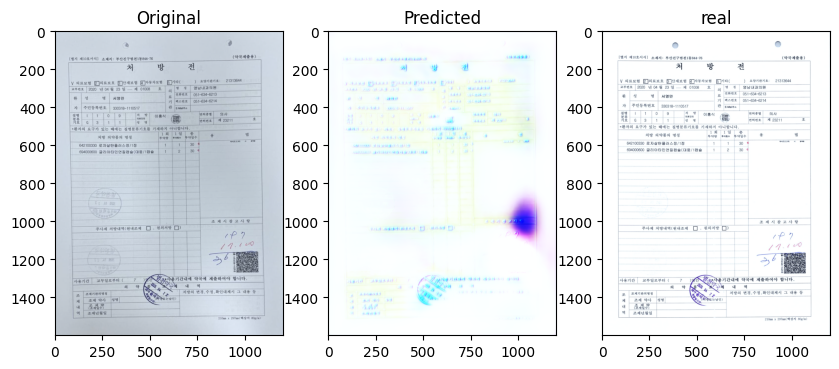

test_loss: 0.2620 -- best loss: 0.2620 --- 232.66 s
cur_lr: 0.001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


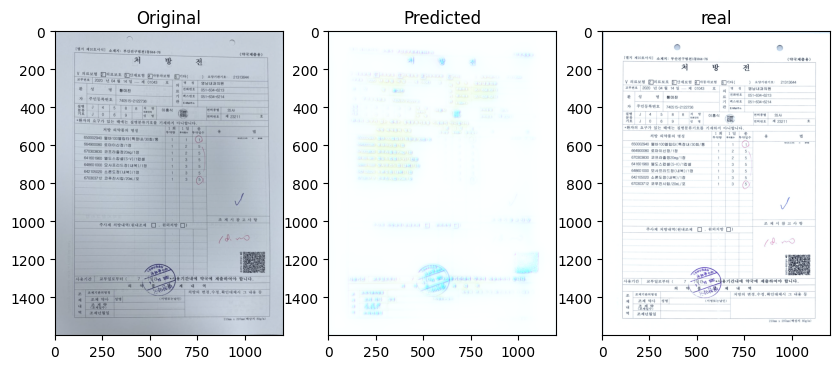

[2 / 5000] train_loss: 1.6203 -- (dis: 0.3774, gen: 0.4059, per: 51.6694) test_loss: 0.2952 -- best loss: 0.2620 --- 124.77 s
cur_lr: 0.001
[3 / 5000] train_loss: 1.9517 -- (dis: 0.8564, gen: 0.3915, per: 49.8939) test_loss: 4.0824 -- best loss: 0.2620 --- 89.14 s
cur_lr: 0.001
[4 / 5000] train_loss: 1.7114 -- (dis: 0.7271, gen: 0.4308, per: 58.6361) test_loss: 0.3163 -- best loss: 0.2620 --- 72.81 s
cur_lr: 0.001
[5 / 5000] train_loss: 1.9467 -- (dis: 0.8626, gen: 0.5254, per: 52.7180) test_loss: 0.4342 -- best loss: 0.2620 --- 70.52 s
cur_lr: 0.001
[6 / 5000] train_loss: 1.8909 -- (dis: 1.7743, gen: 0.3491, per: 53.0148) test_loss: 0.2920 -- best loss: 0.2620 --- 73.16 s
cur_lr: 0.001
[7 / 5000] train_loss: 2.0616 -- (dis: 0.6340, gen: 0.2711, per: 46.4463) test_loss: 0.3192 -- best loss: 0.2620 --- 72.12 s
cur_lr: 0.001
[8 / 5000] train_loss: 1.9774 -- (dis: 0.4380, gen: 0.3700, per: 50.8078) test_loss: 0.3825 -- best loss: 0.2620 --- 79.81 s
cur_lr: 0.001
[9 / 5000] train_loss: 1.7

In [ ]:
count = 0
grad_clip=None
beta=0.01

unorm = UnNormalize(mean = norm_mean, std = norm_std)

for epoch in range(num_epochs):
    # Train
    
    
    generator.train()
    #discriminator.train()

    train_loss = 0
    train_correct = 0

    start_time = time.time()
    for i, (x, y) in enumerate(trainloader):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        #forward
        fake, _, _, _, _, _, _ = generator(x)
        fake = convert_image(fake, source='[-1, 1]', target='imagenet-norm')
        
         ########################
         #(1) Calculate Perceptual Loss
         ########################
        
        #fake_re = nnf.interpolate(fake, size=(800, 600), mode='bicubic', align_corners=False)
        #y_re = nnf.interpolate(y, size=(800, 600), mode='bicubic', align_corners=False)
        
        fake_re_per = nnf.interpolate(fake, size=(224, 224), mode='bicubic', align_corners=False)
        y_re_per = nnf.interpolate(y, size=(224, 224), mode='bicubic', align_corners=False)


        fake_feature = perceptual_model(fake_re_per)
        real_feature = perceptual_model(y_re_per)

        loss_p = 0
        for i in range(len(fake_feature)):
            loss_p += criterion_p(fake_feature[i], real_feature[i])        
        
        
        ##########################
        # (2) Update Discriminator
        ##########################
        
        #Train with fake
        optimizer_d.zero_grad()
        pred_fake = discriminator(fake)
        #pred_fake = discriminator(fake_re)
        loss_d_fake = criterion_d(pred_fake, False)

        #Train with real
        pred_real = discriminator(y)
        #pred_real = discriminator(y_re)
        loss_d_real = criterion_d(pred_real, True)

        #Average and update
        loss_d_total = (loss_d_fake + loss_d_real) * 0.5
        loss_d_total.backward(retain_graph=True)

        if grad_clip is not None:
            for group in optimizer_d.param_groups:
                for param in group['params']:
                    if param.grad is not None:
                        param.grad.data.clamp_(-grad_clip, grad_clip)
                        
#         if (i+1)%8 == 0:
        optimizer_d.step()
        optimizer_d.zero_grad()
        
        
        
        ###########################
        # (3) Update Generator
        ###########################
        optimizer_g.zero_grad()
        
        
        #Get Discriminator Loss
        pred_fake = discriminator(fake)
        loss_gan = criterion_d(pred_fake, True)
        
        
        #Get Generator Loss
        loss_g = criterion_g(fake, y)
        
        loss_total = (loss_gan) + (loss_g) + (loss_p*beta)
#         loss_total = (loss_gan) + (loss_p*beta)

#         loss_g = criterion_g(fake, y)
#         loss_total = loss_g
        loss_total.backward()
    
        if grad_clip is not None:
            for group in optimizer_g.param_groups:
                for param in group['params']:
                    if param.grad is not None:
                        param.grad.data.clamp_(-grad_clip, grad_clip)
                        
#         if (i+1)%8 == 0:
        optimizer_g.step()
        optimizer_g.zero_grad()

        train_loss += loss_total.item()

    train_loss = train_loss / train_batches

    scheduler.step(1.)

    end_time = time.time()
    
    print(f"[{epoch+1} / {num_epochs}] train_loss: {train_loss:.4f} -- (dis: {loss_gan.item():.4f}, gen: {loss_g.item():.4f}, per: {loss_p.item():.4f})", end = " ")
#     print(f"[{epoch+1} / {num_epochs}] train_loss: {train_loss:.4f} -- (dis: {loss_gan.item():.4f}, per: {loss_p.item():.4f})", end = " ")
#     print(f"[{epoch+1} / {num_epochs}] train_loss: {train_loss:.4f} -- (gen: {loss_g.item():.4f})", end = " ")
    
    
    y_hat = fake
    

    
    if epoch % 20 == 0:

        x = unorm(x.detach())
        y_hat = unorm(y_hat.detach())
        y = unorm(y.detach())
        
        x = torch.permute(x.detach().cpu(), (0, 2,3, 1)).numpy()
        y_hat = torch.permute(y_hat.detach().cpu(), (0, 2,3, 1)).numpy()
        y = torch.permute(y.detach().cpu(), (0, 2,3, 1)).numpy()
        f, axarr = plt.subplots(1,3, figsize=(10,7))
        i = 0
        cur_orig = x[i]
        cur_pred = y_hat[i]
        cur_crop = y[i]
        #cur_scan = scan_images[i]


        axarr[0].imshow(cur_orig)
        axarr[0].title.set_text('Original')

        axarr[1].imshow(cur_pred)
        axarr[1].title.set_text('Predicted')

        axarr[2].imshow(cur_crop)
        axarr[2].title.set_text('real')
        plt.show()
        
        
    generator.eval()
    
    
    ### test acc ###
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in testloader:
            x, y = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            outputs, _,_,_,_,_,_ = generator(x)
              
            outputs = convert_image(outputs, source='[-1, 1]', target='imagenet-norm')
            loss = criterion_g(outputs, y)
            test_loss += loss.item()
            
            
        test_loss = test_loss / test_baches
        
        if(test_loss < best_loss):
            torch.save(generator.module.state_dict(), path_checkpoint)
            best_loss = test_loss
        print(f"test_loss: {test_loss:.4f} -- best loss: {best_loss:.4f} --- {(end_time-start_time):.2f} s")
        print(f"cur_lr: {scheduler.optimizer.param_groups[0]['lr']}")
        
#     unorm = UnNormalize(mean = norm_mean, std = norm_std)
#     x = unorm(x)
#     y_hat = unorm(outputs)
#     y = unorm(y)
    y_hat = outputs



    #for i in range(len(x)):
    

    if epoch % 20 == 0:
        
        x = unorm(x.detach())
        y_hat = unorm(y_hat.detach())
        y = unorm(y.detach())

        x = torch.permute(x.detach().cpu(), (0, 2,3, 1)).numpy()
        y_hat = torch.permute(y_hat.detach().cpu(), (0, 2,3, 1)).numpy()
        y = torch.permute(y.detach().cpu(), (0, 2,3, 1)).numpy()
        
        f, axarr = plt.subplots(1,3, figsize=(10,7))
        i = 0
        cur_orig = x[i]
        cur_pred = y_hat[i]
        cur_crop = y[i]
        #cur_scan = scan_images[i]


        axarr[0].imshow(cur_orig)
        axarr[0].title.set_text('Original')

        axarr[1].imshow(cur_pred)
        axarr[1].title.set_text('Predicted')

        axarr[2].imshow(cur_crop)
        axarr[2].title.set_text('real')
        plt.show()
        
        
    if epoch % 500 == 0:
        path_checkpoint2 = f"./weights/illumination_1600_good_0408_check{epoch}.pth"
        torch.save(generator.module.state_dict(), path_checkpoint2)


In [ ]:
path_checkpoint2 = './weights/illumination_1600_good_0408_fin.pth'
torch.save(generator.module.state_dict(), path_checkpoint2)


In [ ]:
def denormalise(image):
    image = image.numpy().transpose(1, 2, 0)  # PIL images have channel last
    mean = [0.485, 0.456, 0.406]
    stdd = [0.229, 0.224, 0.225]
    image = (image * stdd + mean).clip(0, 1)
    return image
